<a href="https://www.kaggle.com/code/klaidenx/s3-e3-co2-emission?scriptVersionId=139837150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [44]:
#! pip install geopandas folium

In [45]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gps
from shapely.geometry import Point
import folium as fl
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [47]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold,GroupKFold,GridSearchCV,train_test_split as tts
from sklearn.preprocessing import RobustScaler,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse

In [48]:
path="../input/playground-series-s3e20/"

#Reading-Load Data Function
def load_data(path):
    load_training=pd.read_csv(f"{path}/train.csv")
    load_test=pd.read_csv(f"{path}/test.csv")
    return load_training,load_test

train_data,test_data=load_data(path)

In [49]:
# Loading Train Dataframes
train_data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [51]:
#Checking For Missing Data
print(f"There Is A Total of {train_data.isna().sum().sum()} Of Missing Data")
train_data.select_dtypes(include="float64").isna().sum().sum()

There Is A Total of 990091 Of Missing Data


990091

In [52]:
#Filling Null Values
cols=train_data.select_dtypes(include="float64").columns

#Function to fill missing values
def fill_values(data,columns):
    for col in columns:
        data[col].fillna(value=np.mean(data[col]),inplace=True)
    return data
fill_values(train_data,cols).head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,0.000048,0.834848,0.000035,0.158418,-7.925870,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [53]:
train_data.isnull().sum().sum()

0

In [54]:
#Data Description
train_data.describe().T.style.background_gradient(subset=["mean"],cmap="viridis",vmin=0,vmax=2.5)\
                             .background_gradient(subset=["max"],cmap="viridis",vmin=0,vmax=2.5)\
                             .background_gradient(subset=["std"],cmap="Blues",vmin=0,vmax=2.5)

,count,mean,std,min,25%,50%,75%,max
latitude,79023.000000,-1.891072,0.694522,-3.299000,-2.451000,-1.882000,-1.303000,-0.510000
longitude,79023.000000,29.880155,0.810375,28.228000,29.262000,29.883000,30.471000,31.532000
year,79023.000000,2020.000000,0.816502,2019.000000,2019.000000,2020.000000,2021.000000,2021.000000
week_no,79023.000000,26.000000,15.297155,0.000000,13.000000,26.000000,39.000000,52.000000
SulphurDioxide_SO2_column_number_density,79023.000000,0.000048,0.000246,-0.000996,-0.000065,0.000048,0.000117,0.004191
SulphurDioxide_SO2_column_number_density_amf,79023.000000,0.834848,0.167371,0.241822,0.730940,0.834848,0.905362,1.885239
SulphurDioxide_SO2_slant_column_number_density,79023.000000,0.000035,0.000186,-0.000887,-0.000053,0.000035,0.000093,0.004236
SulphurDioxide_cloud_fraction,79023.000000,0.158418,0.064430,0.000000,0.123332,0.158418,0.199492,0.299998
SulphurDioxide_sensor_azimuth_angle,79023.000000,-7.925870,58.019802,-179.537059,-41.806629,-7.925870,30.969258,122.095200
SulphurDioxide_sensor_zenith_angle,79023.000000,37.436189,12.775199,0.099237,31.209518,37.436189,44.906770,66.242012


In [55]:
train_data["Dates"]=pd.to_datetime((train_data["year"]*100+train_data["week_no"]).astype("str")+'0',format="%Y%W%w")

## EDA

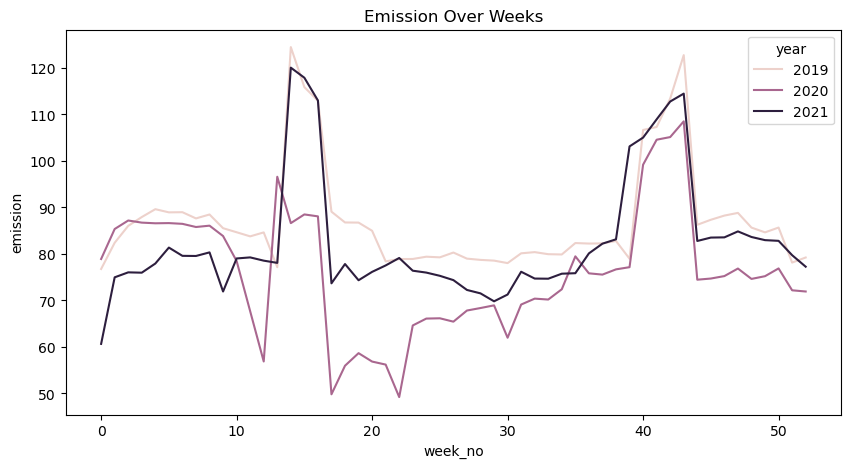

In [56]:
#Visualize Carbon emission over weeks and year
viz_data=train_data.copy()
plt.figure(figsize=(10,5))
sns.lineplot(data=viz_data,x="week_no",y="emission",errorbar=None,hue="year")
plt.title("Emission Over Weeks")
plt.show()

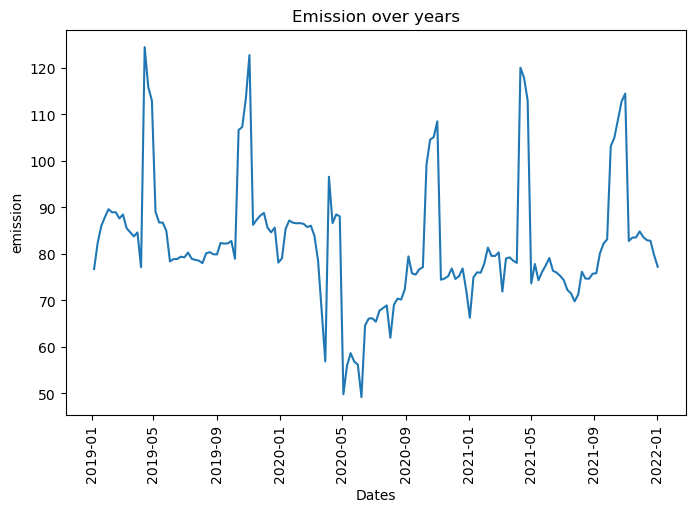

In [57]:
plt.figure(figsize=(8,5))
sns.lineplot(data=viz_data,x="Dates",y="emission",errorbar=None)
plt.xticks(rotation=90)
plt.title("Emission over years")
plt.show()

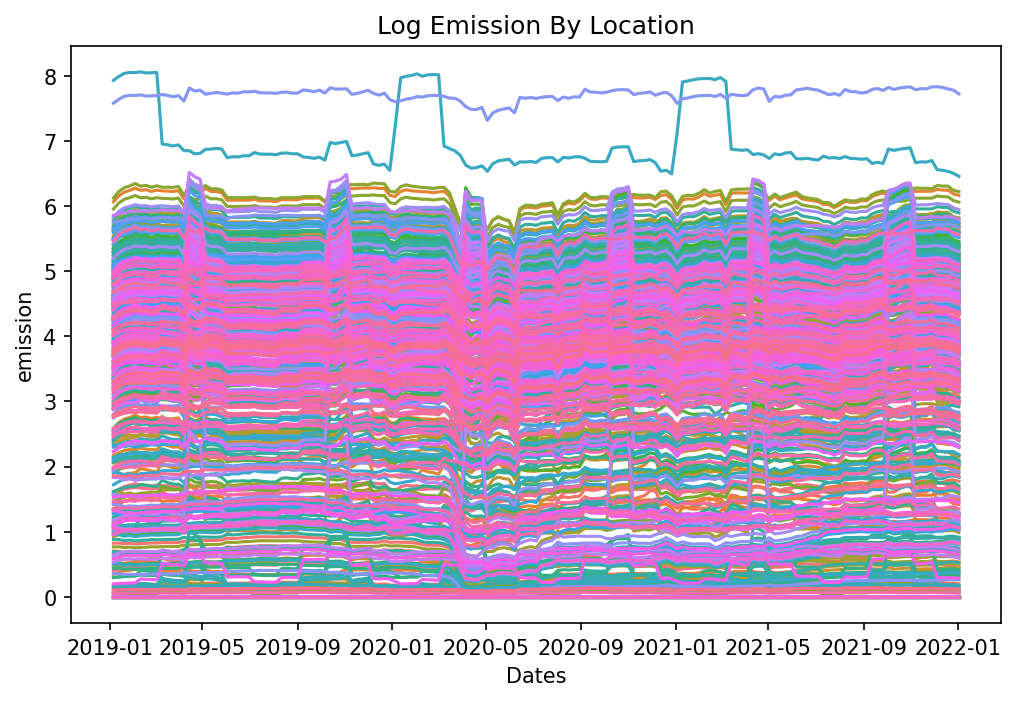

In [58]:
#From kawaicoderUWU

plt.figure(figsize=(8,5),dpi=150)
lon_lat=viz_data["latitude"].astype("str")+"_"+viz_data["longitude"].astype("str")
sns.lineplot(x=viz_data.Dates,y=np.log1p(viz_data.emission),hue=(lon_lat),errorbar=None)
plt.legend().remove()
plt.title("Log Emission By Location")
plt.show()

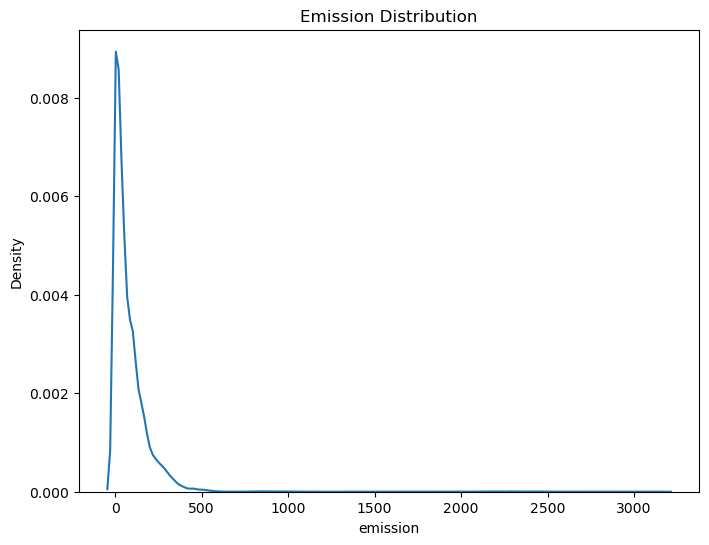

In [59]:
plt.figure(figsize=(8,6))
sns.kdeplot(viz_data,x="emission")
plt.title("Emission Distribution")
plt.show()

In [60]:
latitude_points,longitude_points=viz_data["latitude"].drop_duplicates(),viz_data["longitude"].drop_duplicates()
geometry=gps.points_from_xy(latitude_points,longitude_points[1:])
geo_df=gps.GeoDataFrame(viz_data[["latitude","longitude"]].values[:452],geometry=geometry)
geo_df["latitude"]=geo_df[0]
geo_df["longitude"]=geo_df[1]
geo_df.drop(columns=[0,1],inplace=True)

In [61]:
plt.figure(figsize=(15,8))
fig=px.scatter_geo(geo_df,lat=latitude_points,lon=longitude_points[1:],color=viz_data.iloc[:452]["emission"],size=viz_data.iloc[:452]["emission"],size_max=10)
fig.update_layout(
        title = 'EMISSIONS FROM HIGHEST TO LOWEST',
        geo = dict(
            scope='africa',
            showland = True,
            showlakes=True,
            landcolor = "LightGreen",
            lakecolor="LightBlue",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "LightGreen",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

<Figure size 1500x800 with 0 Axes>

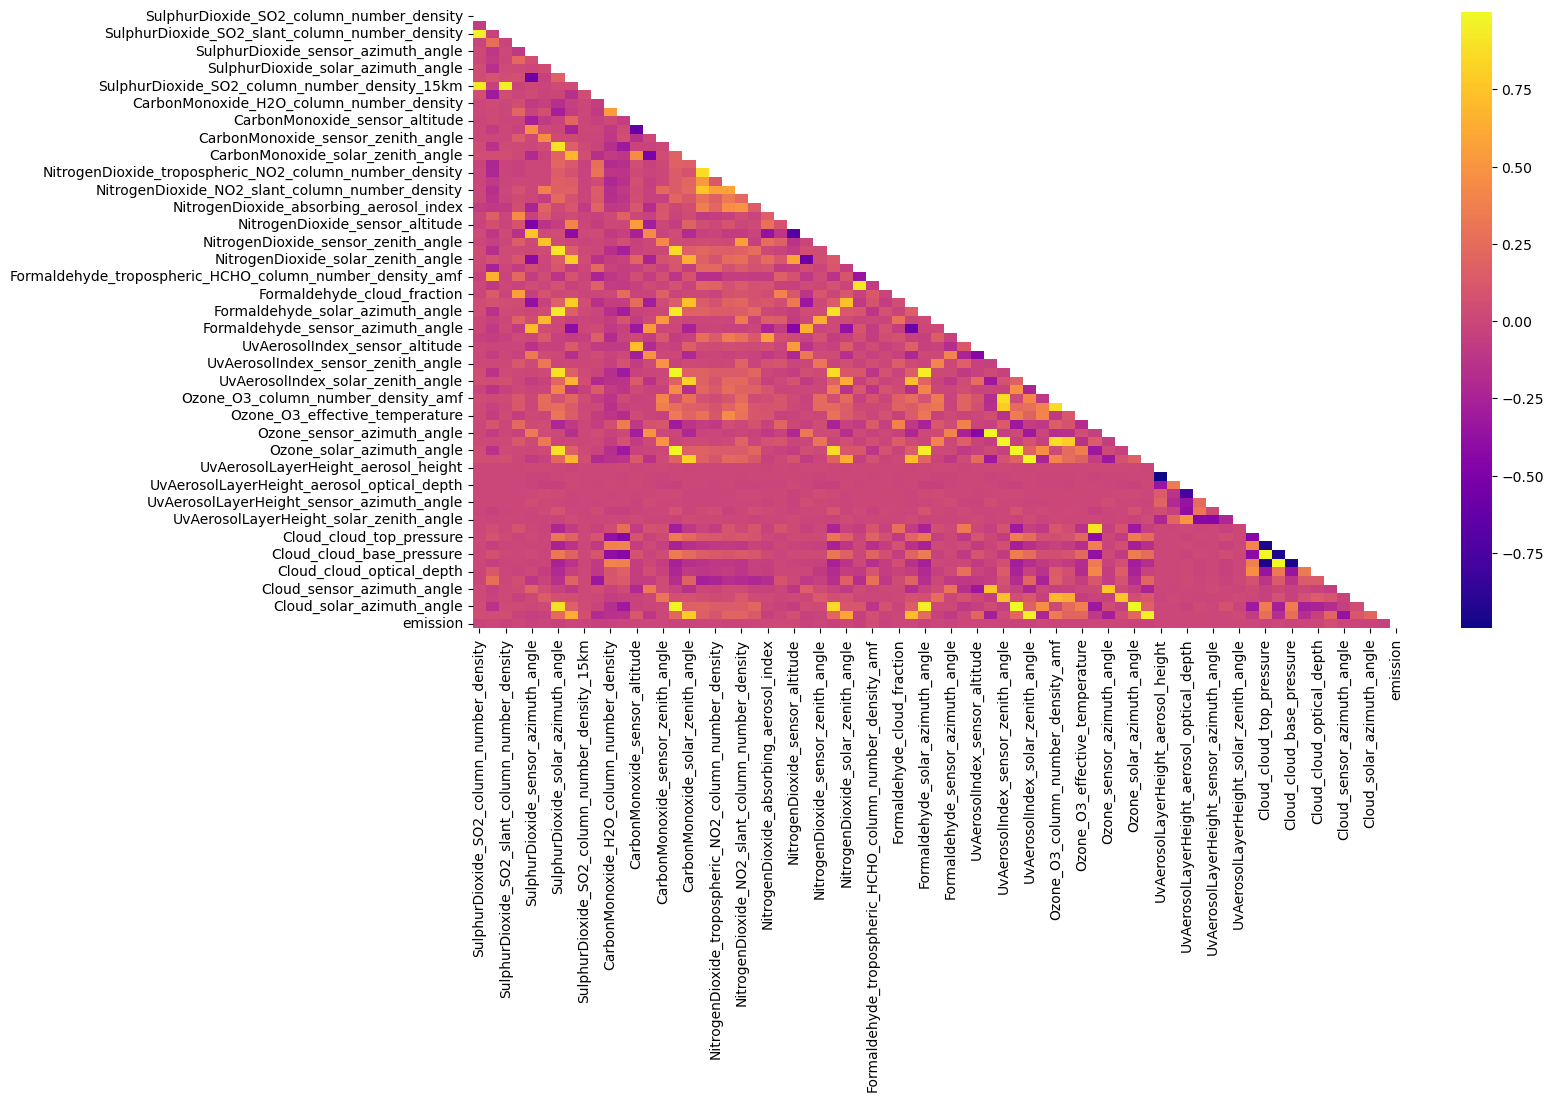

In [62]:
#Vizualise the corrolation between the data
gas_cols=viz_data.select_dtypes(include="float64").columns.to_list()[2:]
corr=viz_data[gas_cols].corr()
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(15,8))
sns.heatmap(corr,mask=mask,cmap="plasma")
plt.show()

# Preparing Data

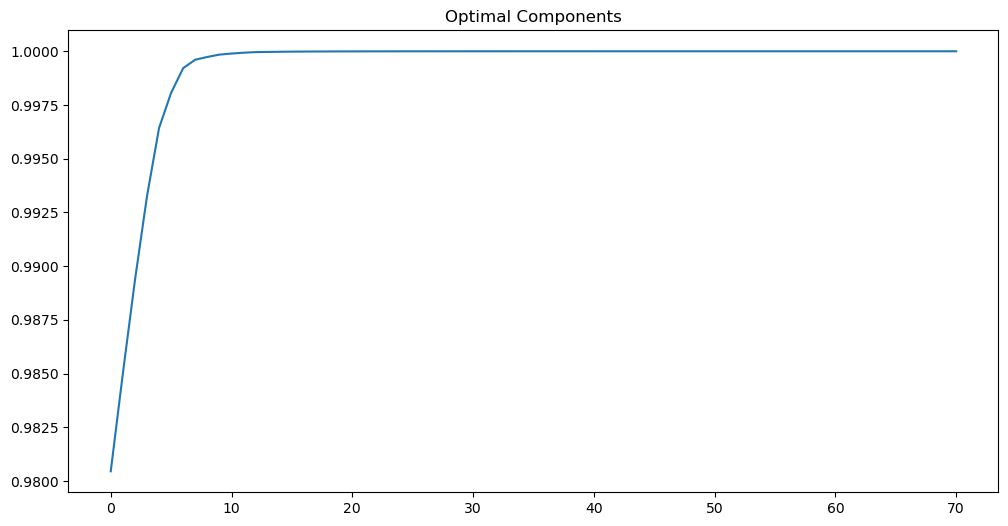

In [63]:
class OptimalComponents:
    n_components=None
    
    def __init__(self,data,pca):
        self.data=data
        self.pca=pca
        
    def get_ncomponents(self,columns):
        pca=self.pca(n_components=self.n_components)
        pca.fit(self.data[columns])
        ratio=pca.explained_variance_ratio_
        cummilative_sum=np.cumsum(ratio)
        
        plt.figure(figsize=(12,6))
        sns.lineplot(cummilative_sum)
        plt.title("Optimal Components")
        plt.show()
    
decomposition=OptimalComponents(viz_data,PCA)
decomposition.get_ncomponents(cols[2:])

In [64]:
class Decompose(OptimalComponents):
    def __init__(self,data,pca):
        super().__init__(data,pca)
     
    def decomposition(self,columns,scaler):
        self.n_components=5
        
        rs=scaler
        self.data[columns[2:-1]]=rs.fit_transform(self.data[columns[2:-1]])
        
        pca=self.pca(n_components=self.n_components)
        pca.fit(self.data[columns[2:-1]])
        return pd.DataFrame(pca.transform(self.data[columns[2:-1]]),columns=["component_%i" %i for i in range(self.n_components)])
    
decomposition=Decompose(train_data,PCA)
new_df=decomposition.decomposition(cols,RobustScaler())

In [65]:
def select_columns(data):
    return data[["latitude","longitude","year","week_no","Dates","emission"]]

train_data=select_columns(train_data)

In [66]:
#covid flag and getting months
train_data["covid_flag"]=np.where((train_data["year"]==2020)&(train_data["week_no"]<=8)&(train_data["week_no"] <= 40),1,0)
train_data["month"]=train_data["Dates"].dt.month

In [67]:
#cos sin of weeks
train_data["cos_week"]=np.cos(train_data["week_no"]*((2*np.pi)/max(train_data["week_no"])))
train_data["sin_week"]=np.sin(train_data["week_no"]*((2*np.pi)/max(train_data["week_no"])))

In [68]:
#reset index before concatination to avoid getting nan values
train_data.reset_index(drop=True,inplace=True)
new_df.reset_index(drop=True,inplace=True)
#concatinate data
full_data=pd.concat([train_data,new_df],axis=1)

In [69]:
#drop cols
full_data["lon_lat"]=full_data["longitude"].astype("str")+"_"+train_data["latitude"].astype("str")
full_data["lon_lat"]=full_data["lon_lat"].astype("category")

full_data.drop(columns=["Dates"],axis=1,inplace=True)
#reorder the new data
new_cols=[i for i in full_data.columns if i!="emission"]
new_cols.append("emission")
full_data=full_data[new_cols]

#train_data["lon_lat"]=train_data["longitude"].astype("str")+"_"+train_data["latitude"].astype("str")
#train_data["lon_lat"]=train_data["lon_lat"].astype("category")

#train_data.drop(columns=["Dates"],axis=1,inplace=True)
#reorder the new data
#new_cols=[i for i in train_data.columns if i!="emission"]
#new_cols.append("emission")
#train_data=train_data[new_cols]

In [70]:
class Models:
    #xgb=XGBRegressor(verbose=False)
    #cat=CatBoostRegressor(verbose=False)
    lgbm=LGBMRegressor()
    #tree=DecisionTreeRegressor()

In [71]:
X=full_data[new_cols[:-1]]
y=full_data[new_cols[-1]]

kf=GroupKFold(n_splits=3)
model_predictions=[]

for i,(train_idx,test_idx) in enumerate(kf.split(X,groups=X["year"])):
    X_train,X_test=X.iloc[train_idx],X.iloc[test_idx]
    y_train,y_test=y.iloc[train_idx],y.iloc[test_idx]
    
    
    X_train = X_train.drop(columns = 'year', axis = 1)
    X_test = X_test.drop(columns = 'year', axis = 1)
    
    print("--"*35)
    
    Models.lgbm.fit(X_train,y_train)
    lgbm_pred=Models.lgbm.predict(X_test)
    model_predictions.append(lgbm_pred)
    
    print(f"Sqaured Error Of The {i+1} Iteration Is {mse(y_test,lgbm_pred,squared=False)}")


----------------------------------------------------------------------
Sqaured Error Of The 1 Iteration Is 18.711749353648955
----------------------------------------------------------------------
Sqaured Error Of The 2 Iteration Is 28.14659004124595
----------------------------------------------------------------------
Sqaured Error Of The 3 Iteration Is 22.75365504962639
